<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1aS4vX-ucDKBmZmZMrBwgjl_DvLAadX2C" width=900/></p>


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. RAG.

В этом домашнем задании вам предстоит создать туристический RAG, провести EDA и проявить креатив! :)

Вам дан набор данных, содержащий информацию о памятниках, архитектуре и других значимых местах. В данных есть:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание (извлеченное из WikiData);
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания.

Часть данных взята с Национальной технологической олимпиады студентов по CV. Базовое решение предполагает использование мультимодального ru-CLIP. Но в данном домашнем задании предлагается решить эту задачу творчески, используя NLP подход.

## Установка и импорт библиотек

In [1]:
!pip install -q gdown torch transformers transformers==4.49 accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl datasets langchain-community ragatouille umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 134.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import gdown
import pandas as pd
from tqdm.notebook import tqdm
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from langchain.docstore.document import Document as LangchainDocument
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import numpy as np
import plotly.express as px
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from ragatouille import RAGPretrainedModel

#------------------------------------------------------------------------------------
# from langchain.text_splitter import ... # выберите другую стратегию разбивки на чанки

# pd.set_option("display.max_colwidth", None)

## Загрузка данных (4 балла)

In [4]:
url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'
output = 'file.csv'

gdown.download(url, output, quiet=False)

data = pd.read_csv('file.csv')

Downloading...
From (original): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk
From (redirected): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk&confirm=t&uuid=c7671b7e-00ff-4a44-9e99-a666e1a0b3ba
To: /content/file.csv
100%|██████████| 672M/672M [00:14<00:00, 46.1MB/s]


In [4]:
data.head()

,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,2,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
3,3,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
4,4,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a boat that is in the water near a bu...


Для декодирования изображений, закодированных в формате base64, можно использовать следующий код:

In [5]:
import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from io import BytesIO

In [6]:
def get_image(data):
  image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
  return image

In [ ]:
print(data['description'][200])
get_image(data['image'][200])

В данных есть выбросы — записи, не относящихся к туристическим или историческим объектам. Для очистки данных можно, например, использовать алгоритм TF-IDF: создаем корпус текстов из описаний, применяем TF-IDF, извлекаем наиболее редко или часто встречающиеся слова. Они могут указывать на мусорные данные, такие как мемы, баннеры или личные фото людей. После выделения подозрительных паттернов, можно провести ручную проверку и фильтрацию данных.

Для дальнейшего тестирования и получения чистых сэмплов, рекомендуется взять не менее 100 чистых образцов со стратификацией по городу и названию места. Это можно сделать, выбрав случайным образом несколько образцов из каждой категории (город + название места), чтобы обеспечить равномерное представительство и разнообразие данных.

**!! Важно:** Помните, что чистые сэмплы одного и того же места выдадут примерно одинаковое описание. Есть несколько стратегий, как повысить разнообразие ответов:

- выбор одного самого лучшего:
  - самое длинное описание
  - смое подходящие по мнению LLM
- конкатенация описаний (но важно не сконкатенировать слишком много)

Изображения можно отдать в мета-данные.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14634 entries, 0 to 14633
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   14634 non-null  int64  
 1   Name         14634 non-null  object 
 2   WikiData     12078 non-null  object 
 3   City         14634 non-null  object 
 4   Lon          14634 non-null  float64
 5   Lat          14634 non-null  float64
 6   description  12078 non-null  object 
 7   image        14634 non-null  object 
 8   en_txt       14634 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.0+ MB


In [7]:
data = data.drop('Unnamed: 0', axis=1)

In [ ]:
data

,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
3,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
4,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a boat that is in the water near a bu...
...,...,...,...,...,...,...,...,...
14629,Ярославское художественное училище,Q4538931,Ярославль,39.876846,57.609852,Ярославское художественное училище,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a statue of a man on a staircase in a...
14630,Ярославское художественное училище,Q4538931,Ярославль,39.876846,57.609852,Ярославское художественное училище,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a large red brick building with many ...
14631,Ярославское художественное училище,Q4538931,Ярославль,39.876846,57.609852,Ярославское художественное училище,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are statues on the wall of a building wi...
14632,Ярославское художественное училище,Q4538931,Ярославль,39.876846,57.609852,Ярославское художественное училище,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,cars are parked in front of a large brick buil...


In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

data = data.copy()

tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(data["en_txt"].fillna(""))

high_idf_words = tfidf.get_feature_names_out()[np.argsort(-tfidf.idf_)[:800]]
bad_keywords = set(high_idf_words)

mask = data["en_txt"].fillna("").apply(
    lambda text: any(word in text.lower() for word in bad_keywords)
)
data_clean = data[~mask]

data_clean["Place"] = data_clean["Name"] + " " + data_clean["City"]

sampled_data = (
    data_clean.groupby("Place", group_keys=False)
    .apply(lambda x: x.sample(min(3, len(x))))
)

print(f"Исходный размер: {len(data)}, После очистки: {len(data_clean)}, Выборка: {len(sampled_data)}")

<ipython-input-8-d0f8f131b16b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean["Place"] = data_clean["Name"] + " " + data_clean["City"]


Исходный размер: 14634, После очистки: 8043, Выборка: 1166


<ipython-input-8-d0f8f131b16b>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(3, len(x))))


In [ ]:
sampled_data

,Name,WikiData,City,Lon,Lat,description,image,en_txt,Place
8634,1941-1945,NaN,Владимир,40.362949,56.111187,NaN,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,soldiers in a trench with a machine gun in fro...,1941-1945 Владимир
8655,1941-1945,NaN,Владимир,40.362949,56.111187,NaN,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed image of two men in uniform holding a map,1941-1945 Владимир
8656,1941-1945,NaN,Владимир,40.362949,56.111187,NaN,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,a close up of a plaque with a man's face and a...,1941-1945 Владимир
9912,2000 летию Рождества Христова,NaN,Владимир,40.408882,56.127674,NaN,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a sign with pictures of a monument on it,2000 летию Рождества Христова Владимир
9911,2000 летию Рождества Христова,NaN,Владимир,40.408882,56.127674,NaN,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,statue of a man holding a cross in a doorway i...,2000 летию Рождества Христова Владимир
...,...,...,...,...,...,...,...,...,...
42,№32 Дом обороны,Q55209768,Екатеринбург,60.601315,56.834167,здание в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a sign on top of it in a ...,№32 Дом обороны Екатеринбург
48,№32 Дом обороны,Q55209768,Екатеринбург,60.601315,56.834167,здание в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,cars are parked in front of a building with a ...,№32 Дом обороны Екатеринбург
1393,№34 Дом контор,Q42296354,Екатеринбург,60.599091,56.833920,Дом контор,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed view of a busy city street with a bus a...,№34 Дом контор Екатеринбург
1402,№34 Дом контор,Q42296354,Екатеринбург,60.599091,56.833920,Дом контор,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a horse drawn carriage in...,№34 Дом контор Екатеринбург


Здесь предлагаем вам построить RAG с использованием моделей, которые не были представлены на семинаре (включая другие векторные базы данных). Можно воспользоваться материалами по этой ссылке: [data_connection/vectorstores](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/).

!Важно, не забудьте отранжировать чанки текстов с помощью `ragatouille`. На практике порядок текстов в промпте влияет на точность ответа.

In [9]:
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["en_txt"], metadata={"source": doc["WikiData"]}) for _, doc in tqdm(sampled_data.iterrows())
]

0it [00:00, ?it/s]

In [10]:
model_name = "BAAI/bge-small-en"
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True}
)

vector_store = FAISS.from_documents(
    RAW_KNOWLEDGE_BASE,
    embeddings,
    distance_strategy=DistanceStrategy.COSINE
)

<ipython-input-10-3f596286377d>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [11]:
from typing import List, Tuple, Dict
from sentence_transformers import CrossEncoder
from langchain.schema import Document

def search_with_cross_encoder(
    query: str,
    vector_store,
    retrieve_k: int = 50,
    rerank_k: int = 5,
    filters: Dict = None
) -> List[Tuple[str, Dict]]:
    docs = vector_store.similarity_search(
        query,
        k=retrieve_k,
        filter=filters
    )

    doc_texts = [doc.page_content for doc in docs]
    doc_metadatas = [doc.metadata for doc in docs]

    if not hasattr(search_with_cross_encoder, "reranker"):
        search_with_cross_encoder.reranker = CrossEncoder(
            "cross-encoder/ms-marco-MiniLM-L-6-v2"
        )

    pairs = [(query, doc_text) for doc_text in doc_texts]
    rerank_scores = search_with_cross_encoder.reranker.predict(pairs)

    ranked_indices = np.argsort(rerank_scores)[-rerank_k:][::-1]

    results = []
    for idx in ranked_indices:
        results.append(
            (doc_texts[idx], doc_metadatas[idx])
        )

    return results

In [19]:
def generate_answer(query: str, context: str, model, tokenizer) -> str:
    """Генерация ответа без повторения инструкции"""
    prompt = (
        f"Контекст: {context}\n\n"
        f"Вопрос: {query}\n\n"
        f"Ответь на вопрос, используя только контекст. Если информации нет, скажи 'Не знаю'.\n\nОтвет:"
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=150, do_sample=True, temperature=0.7)
    return tokenizer.decode(outputs[0], skip_special_tokens=True).split("Ответ:")[-1].strip()

Выполните визуализацию эмбеддингов при помощи метода главных компонент (PCA) и Uniform Manifold Approximation and Projection (UMAP). Пожалуйста, выполните PCA независимо от pacmap.

PCA визуализация:


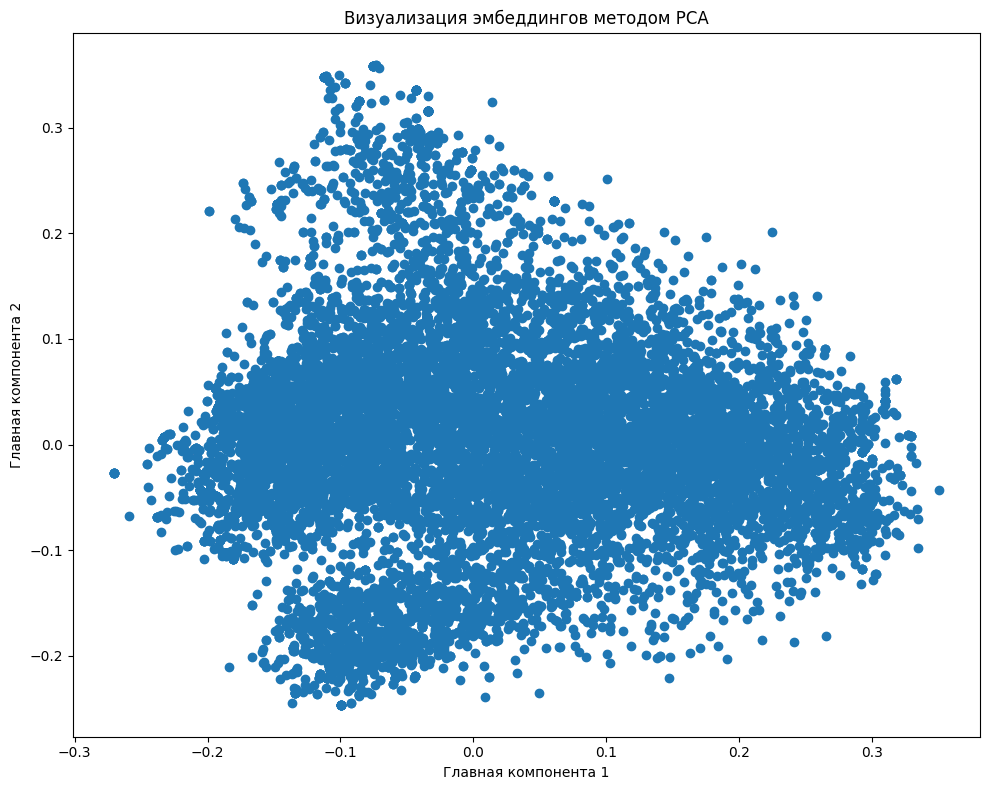


UMAP визуализация:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


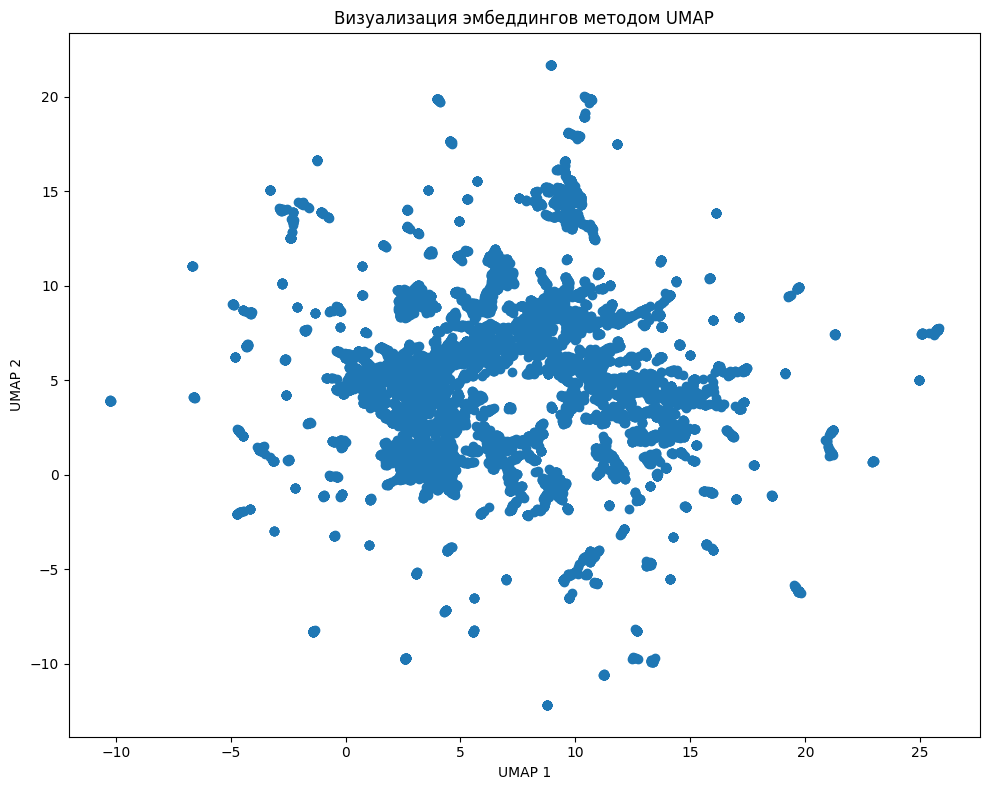

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('BAAI/bge-small-en')
en_txt = data["en_txt"].tolist()
embeddings = model.encode(en_txt)

def plot_pca(embeddings, texts):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1])

    plt.title('Визуализация эмбеддингов методом PCA')
    plt.xlabel('Главная компонента 1')
    plt.ylabel('Главная компонента 2')


    plt.tight_layout()
    plt.show()

def plot_umap(embeddings, texts):
    umap = UMAP(n_components=2, random_state=42)
    umap_result = umap.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    plt.scatter(umap_result[:, 0], umap_result[:, 1])

    plt.title('Визуализация эмбеддингов методом UMAP')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')

    plt.tight_layout()
    plt.show()

print("PCA визуализация:")
plot_pca(embeddings, en_txt)

print("\nUMAP визуализация:")
plot_umap(embeddings, en_txt)

# RAGAS (3 балла)

RAGAS - это система, созданная для автоматической оценки эффективности модели RAG. Она представляет собой комплексный инструмент, способный оценить как качество извлечения информации, так и качество созданного текста. Это достигается благодаря использованию различных метрик, которые анализируют разные аспекты ответов, сгенерированных языковой моделью.



## Метрики оценки в RAGAS

### Faithfulness
Оценивает, насколько ответы языковой модели верно передают информацию, содержащуюся в источниках данных. Это критически важно, чтобы гарантировать, что модель не искажает или не меняет информацию при её интерпретации.

---

$
Faithfulness = \frac{\text{|Number of claims that can be inferred from given context|}}{\text{|Total number of claims in the generated answer|}}
$

### Answer Relevancy
Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного ответа $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

### Context Recall и Context Precision
Эти метрики измеряют эффективность модели в учете контекста вопроса для формирования ответа. "Context Recall" оценивает количество использованной информации из контекста в ответе, в то время как "Context Precision" оценивает точность и релевантность использования контекстной информации.

---

* $ \text{context recall} = \frac{\text{|GT sentences that can be attributed to context|}}{\text{|Number of sentences in GT|}} $
* $Context Precision@k = \frac{\sum \text{precision@k}}{\text{total number of relevant items in the top K results}}$
  * $Precision@k = \frac{\text {true positives@k}}{\text{(true positives@k + false positives@k)}}$

### Answer Semantic Similarity
Оценивает степень семантической близости между ответом модели и эталонным ответом. Это позволяет определить, насколько естественно и точно модель способна воссоздавать человеческий язык.

### Answer Correctness
Оценка корректности ответа. Это последний шаг в проверке, чтобы убедиться, предоставляет ли модель точную и достоверную информацию в своем ответе.

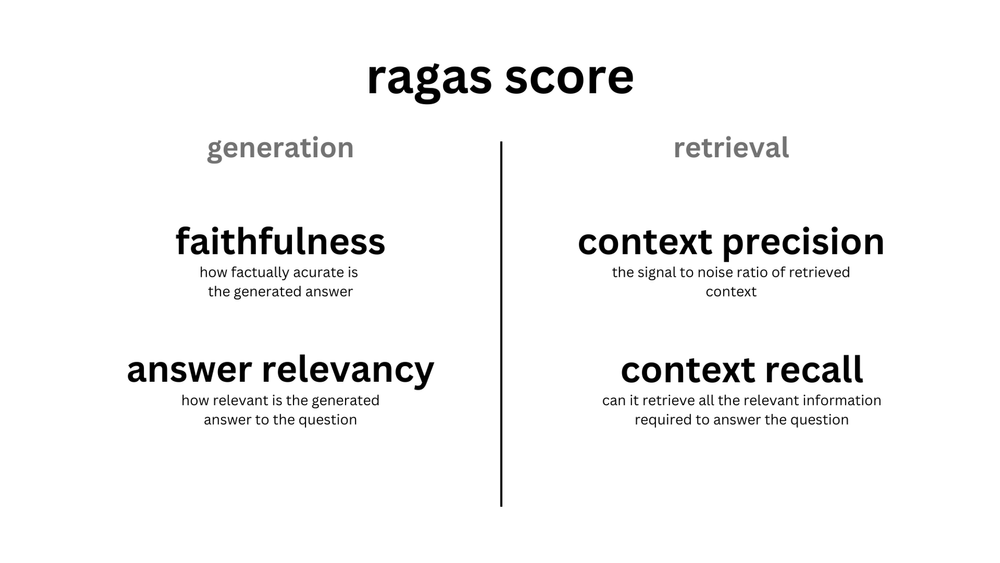

В этом задании вам нужно реализовать метрику answer_relevancy в коде. Опционально за допбаллы можно реализовать другие метрики.

Для этого датасет нужно привести к виду, в котором будут следующие поля:

### 1. question
- Смысл: Эта колонка содержит вопросы, на которые нужно найти ответы. В контексте задач QA, это основная информация, которую модель должна обработать для генерации ответа.
- Пример: "Каковы преимущества RAG?"

### 2. ground_truths
- Смысл: В этой колонке находятся правильные ответы на соответствующие вопросы. Это может использоваться для оценки производительности модели, так как позволяет сравнить сгенерированные ответы с эталонными.
- Пример: "RAG улучшает качество генерации, используя внешние источники информации."

### 3. answer
- Смысл: Эта колонка содержит ответы, которые генерирует модель на основе заданных вопросов. Это может быть результат работы модели, которую вы тестируете или обучаете.
- Пример: "RAG позволяет моделям извлекать информацию из внешних источников, что улучшает их способность отвечать на сложные вопросы."

### 4. contexts
- Смысл: Эта колонка предоставляет контекст или дополнительную информацию, которая может быть полезна для понимания вопроса или для формирования ответа. Это может быть текст, из которого был извлечен ответ, или другие релевантные документы.
- Пример: "RAG (Retrieval-Augmented Generation) — это метод, который использует внешние базы данных для получения информации при генерации текста."

HINT: Поле question можно тоже сгенерировать. Например, можно попросить модель задать вопрос по описанию изображения.

HINT: Для answer_relevancy нужны не все поля

HINT: Инференс такого эксперимента может быть долгим. План минимум: возьмите 100 случайных сэмплов.

In [13]:
def data_preprocess(df, model, tokenizer, sample_size=100):
    """Подготовка данных с генерацией ответов"""
    if len(df) > sample_size:
        df = df.sample(sample_size, random_state=42)

    processed_data = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Подготовка данных"):
        description = row.get('en_txt', '')
        name = row.get('name', 'этом месте')
        question = f"Что вы можете рассказать о {name}?"

        processed_data.append({
            'question': question,
            'ground_truths': [description],
            'answer': generate_answer(question, description, model, tokenizer),
            'contexts': [row.get("description", "")]
        })

    return pd.DataFrame(processed_data)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

def answer_relevancy(questions: list, answers: list) -> np.ndarray:
    """Вычисление релевантности с обработкой ошибок"""
    model = SentenceTransformer('BAAI/bge-small-en')
    scores = []

    for q, a in tqdm(zip(questions, answers), total=len(questions)):
        try:
            # Векторизация вопроса и ответа
            q_embed = model.encode(q, convert_to_tensor=True).cpu().numpy().reshape(1, -1)
            a_embed = model.encode(a, convert_to_tensor=True).cpu().numpy().reshape(1, -1)

            # Вычисление косинусной схожести
            score = cosine_similarity(q_embed, a_embed)[0][0]
            scores.append(score)
        except Exception as e:
            print(f"Ошибка для вопроса '{q[:50]}...': {str(e)}")
            scores.append(np.nan)

    return np.array(scores)

# Протестируйте ваш RAG (3 балла)

In [16]:
model_name = "teknium/OpenHermes-2.5-Mistral-7B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
df = data_preprocess(data_clean, model, tokenizer)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Подготовка данных:   0%|          | 0/100 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end gene

Оценка релевантности:   0%|          | 0/4 [00:00<?, ?it/s]

AttributeError: 'dict' object has no attribute 'mean'

In [29]:
questions = df['question'].tolist()
answers = df['answer'].tolist()

test_data = {
    "question": questions,
    "answer": answers
}

# Вычисление релевантности
scores = answer_relevancy(test_data["question"], test_data["answer"])

# Анализ результатов
print(f"\nСредняя релевантность: {np.nanmean(scores):.3f}")
print(f"Медианная релевантность: {np.nanmedian(scores):.3f}\n")

# Топ-3 самых релевантных ответов
print("Самые релевантные ответы:")
for idx in np.argsort(scores)[-3:][::-1]:
    print(f"Q: {test_data['question'][idx]}")
    print(f"A: {test_data['answer'][idx]}")
    print(f"Score: {scores[idx]:.3f}\n")

# Топ-3 наименее релевантных ответов
print("Наименее релевантные ответы:")
for idx in np.argsort(scores)[:3]:
    print(f"Q: {test_data['question'][idx]}")
    print(f"A: {test_data['answer'][idx]}")
    print(f"Score: {scores[idx]:.3f}\n")

  0%|          | 0/100 [00:00<?, ?it/s]


Средняя релевантность: 0.838
Медианная релевантность: 0.839

Самые релевантные ответы:
Q: Что вы можете рассказать о этом месте?
A: Ты — туристический помощник. Отвечай ТОЛЬКО по контексту.
    Контекст: there is a picture of a mountain with a man and a dog
    Вопрос: Что вы можете рассказать о этом месте?
    Если информации нет, скажи "Уточните запрос".

Ответ: Это изображение показывает гору, на которой стоит мужчина с собакой. Может быть, это место предназначено для альпинизма или просто для прогулок с собакой.

Ответ: На изображении видно гору, на которой стоит мужчина с собакой. Возможно, это место предназначено для альпинизма или прогулок с собакой.

Ответ: На изображении показана гора, на которой стоит мужчина с собакой. Возможно, это место подходит для альпинизма или прогулок с собакой.
Score: 0.872

Q: Что вы можете рассказать о этом месте?
A: Ты — туристический помощник. Отвечай ТОЛЬКО по контексту.
    Контекст: a close up of a painting of a man in a priest's robes
    Во

In [30]:
sampled

,question,ground_truths,answer,contexts,answer_relevancy
0,Что вы можете рассказать о этом месте?,[there are many children sitting at a table in...,Ты — туристический помощник. Отвечай ТОЛЬКО по...,[nan],NaN
1,Что вы можете рассказать о этом месте?,[arafed church with a steeple on the top of it],Ты — туристический помощник. Отвечай ТОЛЬКО по...,[Православный храм в Ярославле],NaN
2,Что вы можете рассказать о этом месте?,[a close up of a painting of a man in a priest...,Ты — туристический помощник. Отвечай ТОЛЬКО по...,[nan],NaN
3,Что вы можете рассказать о этом месте?,[a close up of a building with a clock on it],Ты — туристический помощник. Отвечай ТОЛЬКО по...,[церковь в Нижнем Новгороде],NaN
4,Что вы можете рассказать о этом месте?,[arafed view of a stadium with a field and a r...,Ты — туристический помощник. Отвечай ТОЛЬКО по...,[стадион в Екатеринбурге],NaN
...,...,...,...,...,...
95,Что вы можете рассказать о этом месте?,[there is a picture of a mountain with a man a...,Ты — туристический помощник. Отвечай ТОЛЬКО по...,[nan],NaN
96,Что вы можете рассказать о этом месте?,[there is a rock formation with moss growing o...,Ты — туристический помощник. Отвечай ТОЛЬКО по...,[геологический и археологический памятник прир...,NaN
97,Что вы можете рассказать о этом месте?,[there is a large building with a clock on the...,Ты — туристический помощник. Отвечай ТОЛЬКО по...,[Нижегородский государственный академический т...,NaN
98,Что вы можете рассказать о этом месте?,[a statue of a man with a beard and a bust],Ты — туристический помощник. Отвечай ТОЛЬКО по...,[Памятник Леониду Трефолеву (Ярославль)],NaN


# Дополнительная часть (+3 балла)

Реализуйте одну из метрик retrieval-части на выбор.

Для того, чтобы понять model as a judge подход из RAGAS, советуем посетить [этот кукбук](https://huggingface.co/learn/cookbook/en/rag_evaluation)

In [ ]:
# your code here